# **Variational Autoencoder:**

Variational autoencoder extend the basic autoencoder framework by introducing probabilistic modeling in the encoding and decoding processes. VAEs encode input data onto a distribution in the latent space. Now, to enable backpropagation through the sampling process, VAEs use the reparameterization trick - instead of sampling directly from the distribution, the model samples from a fixed distribution (generally the standard normal one) and then scales and shifts the samples based on the mean and standard deviation produced by the encoder.

The latent space of VAEs represents a continuous space where neighbouring points correspond to similar data points. This property allows for smooth interpolation and generation of new data points by sampling from the learned probability distribution in the latent space. The loss function in VAEs involve an additional term than the reconstruction loss - the  KL divergence term which encourages the learned distribution in the latent space to be close to a predefined distribution (generally a standard normal distribution).

The generative nature of VAEs make them suitable for tasks such as image generation, data augmentation, transfer learning, domain adaptation, etc.

In [2]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, BatchNormalization
from keras.models import Model
from keras.datasets import cifar10
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
(x_train, y_train), (x_test, y_test)=cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [5]:
img_width  = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 3
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)
print(input_shape)

(32, 32, 3)


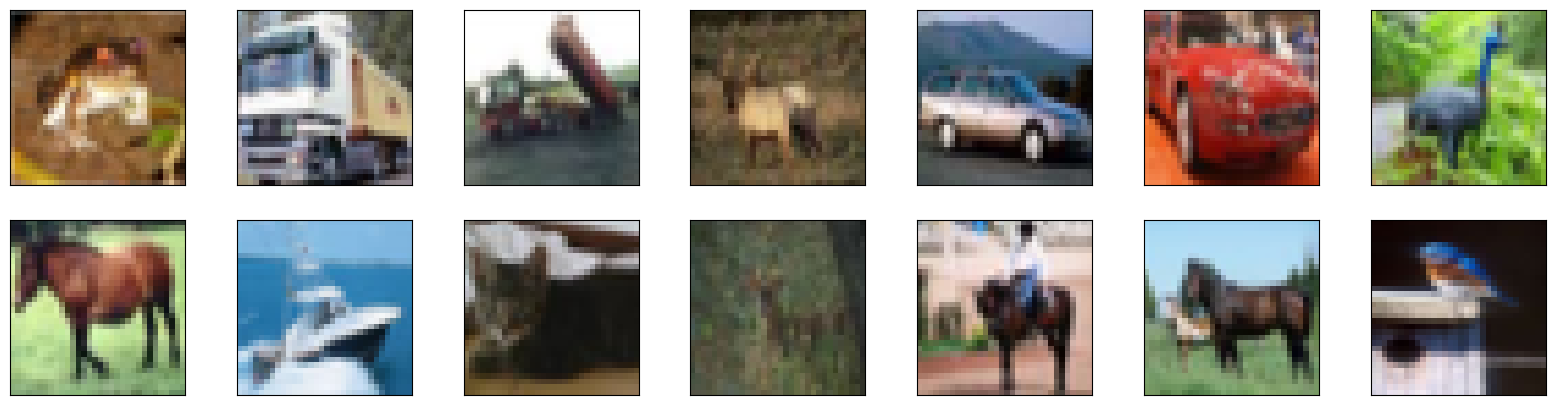

In [6]:
plt.figure(figsize=(20, 5))
for i in range(14):
  ax=plt.subplot(2, 7, i+1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.imshow(x_train[i])
plt.show()

In [7]:
latent_dim = 64

In [8]:
input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x)
print(conv_shape)

(None, 16, 16, 64)


In [9]:
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

In [10]:
z_mu = Dense(latent_dim, name='latent_mu')(x)
z_sigma = Dense(latent_dim, name='latent_sigma')(x)

In [11]:
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

In [12]:
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

In [13]:
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 16, 16, 64)           36928     ['conv2d_1[0][0]']            
                                                                                            

In [14]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

In [15]:
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

decoder = Model(decoder_input, x, name='decoder')
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 64)]              0         
                                                                 
 dense_1 (Dense)             (None, 16384)             1064960   
                                                                 
 reshape (Reshape)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 32)        18464     
 anspose)                                                        
                                                                 
 decoder_output (Conv2DTran  (None, 32, 32, 3)         867       
 spose)                                                          
                                                                 
Total params: 1084291 (4.14 MB)
Trainable params: 1084291 (

In [16]:
z_decoded = decoder(z)

In [17]:
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)

        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomLayer()([input_img, z_decoded])

In [18]:
vae = Model(input_img, y, name='vae')
vae.compile(optimizer='adam', loss=None)
print(vae.summary())

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 16, 16, 64)           36928     ['conv2d_1[0][0]']            
                                                                                                

In [19]:
vae.fit(x_train, None, epochs = 20, validation_split = 0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
39840/40000 [============================>.] - ETA: 0s - loss: 0.6060

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


40000/40000 [==============================] - 16s 409us/sample - loss: 0.6059 - val_loss: 0.5969
Epoch 2/20
40000/40000 [==============================] - 9s 216us/sample - loss: 0.5957 - val_loss: 0.5959
Epoch 3/20
40000/40000 [==============================] - 8s 198us/sample - loss: 0.5946 - val_loss: 0.5950
Epoch 4/20
40000/40000 [==============================] - 9s 218us/sample - loss: 0.5939 - val_loss: 0.5949
Epoch 5/20
40000/40000 [==============================] - 11s 277us/sample - loss: 0.5934 - val_loss: 0.5944
Epoch 6/20
40000/40000 [==============================] - 11s 286us/sample - loss: 0.5930 - val_loss: 0.5941
Epoch 7/20
40000/40000 [==============================] - 10s 262us/sample - loss: 0.5926 - val_loss: 0.5938
Epoch 8/20
40000/40000 [==============================] - 11s 283us/sample - loss: 0.5923 - val_loss: 0.5939
Epoch 9/20
40000/40000 [==============================] - 11s 284us/sample - loss: 0.5921 - val_loss: 0.5936
Epoch 10/20
40000/40000 [========